# Evaluate Timeseries Rerf Performance

In [1]:
import numpy as np
from pathlib import Path
import h5py
import math
import time
from datetime import datetime
from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from rerf.rerfClassifier import rerfClassifier

In [2]:
## Paths
base_dir = Path('/data/ronan/grasp-and-lift-eeg-detection')
load_dir = base_dir / 'processed'

# Columns name for labels
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']

# Number of subjects
subjects = range(1,13)

# data path
prelag = 150
postlag = 300

## Helper functions

In [12]:
def sort_keep_balance(y,block_lengths):
    """
    Sort data and labels into blocks that preserve class balance
    
    Parameters
    ----------
    X: data matrix
    y : 1D class labels
    block_lengths : Block sizes to sort X,y into that preserve class balance
    """
    clss,counts = np.unique(y, return_counts=True)
    ratios = counts / sum(counts)
    class_idxs = [np.where(y==i)[0] for i in clss]

    sort_idxs = []
    
    prior_idxs = np.zeros(len(clss)).astype(int)
    for n in block_lengths:
        get_idxs = np.rint(n*ratios).astype(int)
        for idxs,prior_idx,next_idx in zip(class_idxs,prior_idxs,get_idxs):
            sort_idxs.append(idxs[prior_idx:next_idx])
        prior_idxs = get_idxs
        
    sort_idxs = np.hstack(sort_idxs)
    
    return(sort_idxs)

def load_data(data_dir, lags, subjects):
    """
    Loads processed X,y data
    """
    X = []
    y = []
    for subject in subjects:
        h5 = h5py.File(data_dir / f'subj{subject}_prelag={lags[0]}_postlag={lags[1]}_Xy.hdf5','r')
        X.append(h5['X'][:])
        y.append(h5['y'][:])
        h5.close()
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y)

    return(X,y)

## Train & Test

In [15]:
# Load subject(s) concatenated together
subjects = [1]
X,y = load_data(load_dir, [prelag, postlag], subjects)

MemoryError: Unable to allocate 267. MiB for an array with shape (2430, 14400) and data type float64

In [18]:
# Parameters
n_est = 500
ncores = 4
max_features = int(14400 / 4)#int(math.sqrt(X.shape[1])/4)
HEIGHT = 32
hmax = 6
hmin = 1
WIDTH = int(14400 / HEIGHT)#int(X.shape[1] / HEIGHT)
wmax = 10
wmin = 4

In [3]:
# Define classifier(s)
names = {"TORF":"red"}

classifiers = [rerfClassifier(
                projection_matrix="S-RerF", 
                max_features=max_features,
                n_estimators=n_est,
                n_jobs=ncores,
                image_height=HEIGHT, 
                image_width=WIDTH, 
                patch_height_max=hmax,
                patch_height_min=hmin,
                patch_width_max=wmax,
                patch_width_min=wmin
                )]

NameError: name 'max_features' is not defined

### Optimize Parameters

In [7]:
# Create write file
timestamp = datetime.now().strftime('%m-%d-%H:%M')
f = open(f'EEG_GridSearchCV_{timestamp}.csv', 'w+')
f.write("classifier,parameters,mean_test_score,mean_fit_time,mean_score_time\n")
f.flush()

In [ ]:
# Grid search each classifier and write to file
parameters = [{'patch_height_max':np.arange(4,13,2), 'patch_height_min':[1],
               'patch_width_max':[50,100,200,400], 'patch_width_min':[25]}]
best_classifiers = []

for clf,name,parameters in tqdm(zip(classifiers, names, parameters)):
    gscv = GridSearchCV(clf, parameters, cv=StratifiedShuffleSplit(n_splits=3, test_size=0.1) ,n_jobs=ncores, refit=False)
    gscv.fit(X, y)

    results = gscv.cv_results_

    result_keys = ['params','mean_test_score',
                  'mean_fit_time','mean_score_time']

    cv_results = [', '.join([str(results[key][i]) for key in result_keys]) for i in range(len(results['params']))]
    for cv_result in cv_results:
        f.write(f'{name}, {cv_result}\n')
        f.flush()

    print(f'Best {name} parameters:')
    print(f'{gscv.best_params_}')
    print(f'With score {gscv.best_score_}')

    #best_classifiers.append(gscv.best_estimator_)

0it [00:00, ?it/s]

### Accuracy vs. number of training samples

In [25]:
# # cross-validation train & test splits preserving class percentages
### Accuracy vs. number of training samples
k = 5
test_fraction = 0.2
sss = StratifiedShuffleSplit(n_splits=k, test_size=test_fraction, random_state=0)

# Number of training samples
ns = np.linspace(2,np.log10(math.floor(len(y)*(1-test_fraction))),5)
ns = np.power(10,ns).astype(int)

In [ ]:
# Train & Test
timestamp = datetime.now().strftime('%m-%d-%H:%M')
f = open(f'EEG_classifier_results_{timestamp}.csv', 'w+')
f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
f.flush()

runList = [(n, clf, name) for n in ns\
           for clf,name in zip(classifiers, [name for name in names])]

for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print(f'Fold {i}')
    bal_index = sort_keep_balance(y[train_index],ns)
    
    for n, clf, name in tqdm(runList):
        nIndex = train_index[:n]
        
        trainStartTime = time.time()
        clf.fit(X[nIndex], y[nIndex])
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        testStartTime = time.time()
        yhat = clf.predict(X[test_index])
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        lhat = np.mean(np.not_equal(yhat, y[test_index]).astype(int))

        ####("variable,Lhat,trainTime,testTime,iterate")
        f.write(f"{name}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {i}\n")
        f.flush()

f.close()

## Plot Results

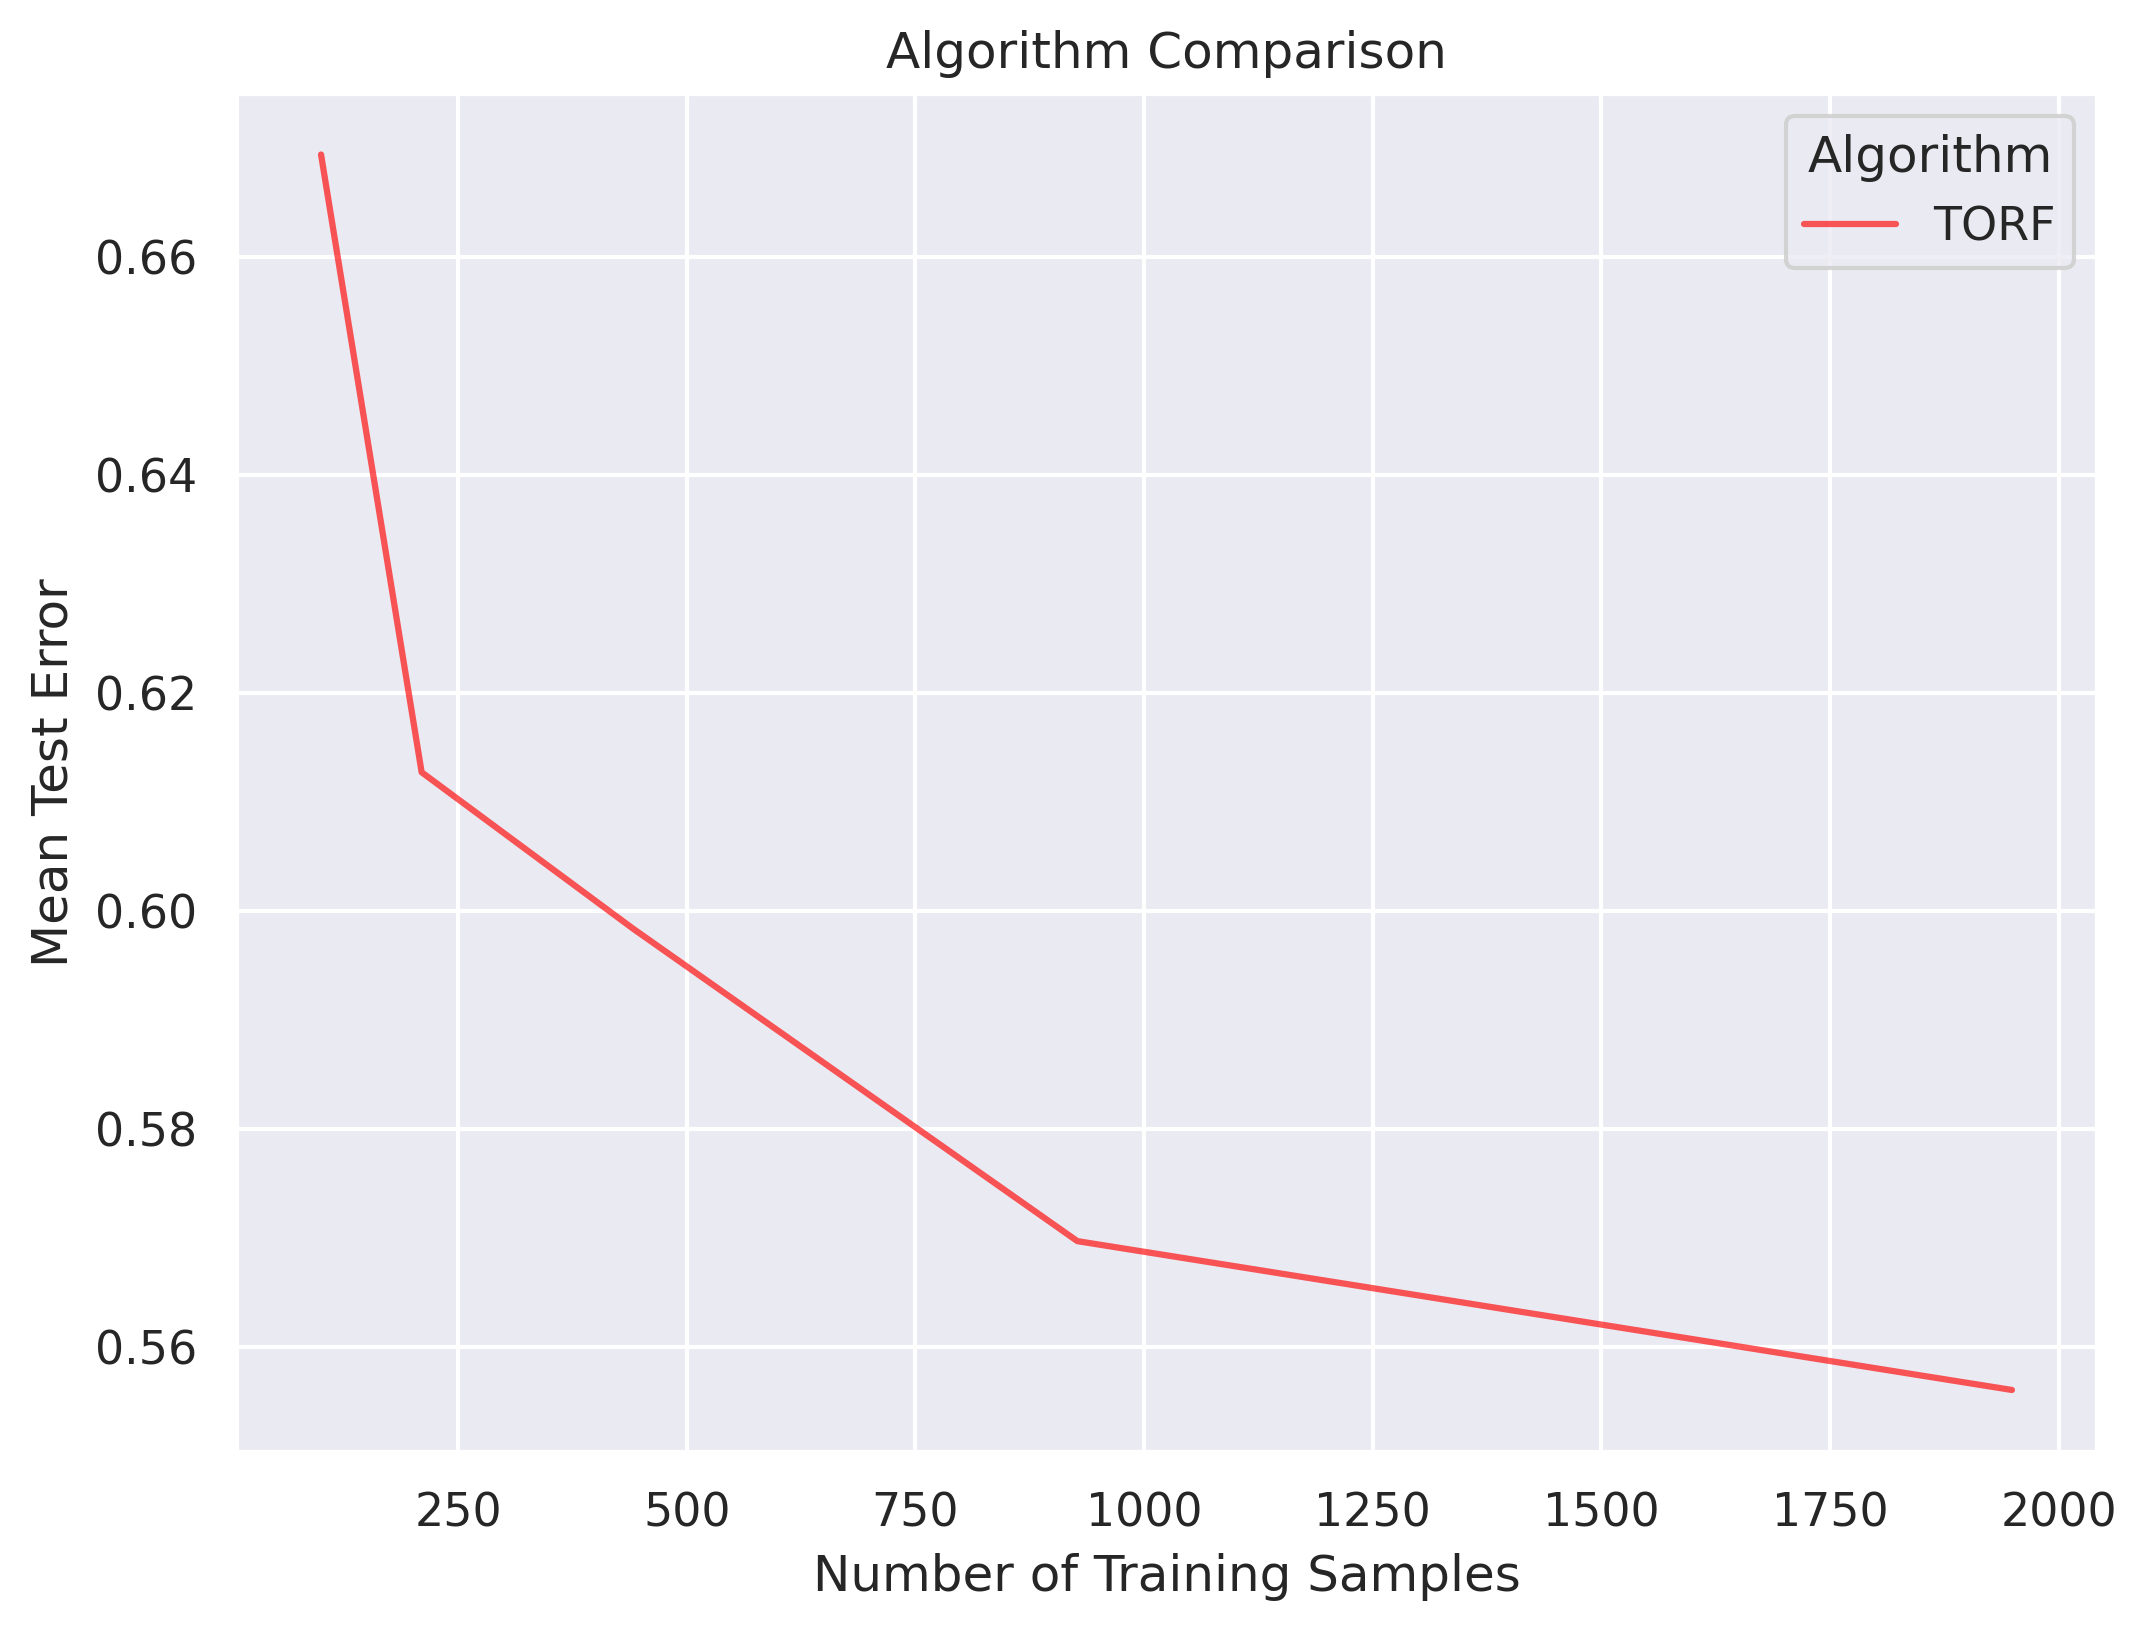

In [4]:
TAG = 'unscaled'
dat = pd.read_csv(f"EEG_classifier_results_{TAG}_03-24-15:33.csv")

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    #ax.set_yscale('log')

plt.legend(loc='best',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Mean Test Error')
plt.xlabel('Number of Training Samples')
#plt.savefig('./s-rerf_impulse_experiment.pdf',dpi=300,format='pdf')
plt.show()
